# Searching $k$ and $\lambda$ using scikit-learn's `GridSearchCV`

The parameter $k$ is essentially the upper limit on the sizes of the prediction sets. Thus, by its definition, we should choose $k$ so that the true class $y$ are within the top-$k$ most likely classes for most samples. Specifically, if we want our prediction set to contain the true class $(1-\alpha)\%$ of the time, a suitable choice of $k$ is the ($1-\alpha$) quantile of the ranks of the true classes based on their predicted probabilities, from highest to lowest.

The `CoverForestClassifier` class provides the `search_k_and_lambda()` method that searches for $k$ using the method described in the previous paragraph; while $\lambda$ is chosen from the candidates $0.001, 0.01, 0.1, 0.2, 0.5, 1$ using cross-validation. In this tutorial, we will instead use the grid-search functionality provided by scikit-learn to search for $k$ and $\lambda$ over any choice of search spaces.

This tutorial demonstrates how to perform grid-search cross-validation for `CoverForestClassifier`'s $k$ and $\lambda$ parameters on the MNIST dataset.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split

from coverforest import CoverForestClassifier
from coverforest.metrics import average_set_size_loss

Load the dataset and take a look at the first few images.

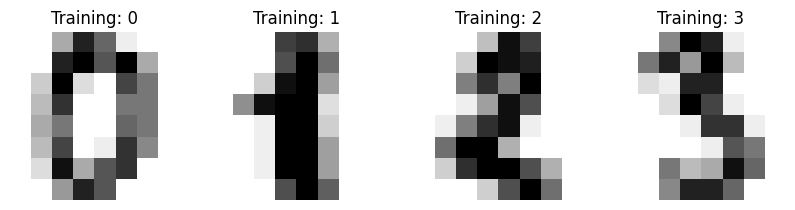

In [2]:
digits = load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

We'll split the data into 50% training and 50% testing sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.5, shuffle=False
)

## Limiting the search space

When dealing with problems that have many possible classes, searching through all possible values of $k$ (from 1 up to the total number of classes) would be computationally expensive. Instead, we can narrow down the search range for $k$ using the quantile-based approach described at the beginning. In particular, we will use the `search_k_and_lambda()` method, which will output a particular value of $k$, then we will limit our search space to integers near this value.

To search for $k$, we specify `k_init="auto"` and `lambda_init=0`. We also set`alpha_default=0.05` which will not be used for now, but it will be used when `GridSearchCV` calls `clf`'s `predict()` method during fitting.

In [4]:
clf = CoverForestClassifier(
    n_estimators=100,
    method="cv",
    cv=5,
    k_init="auto",
    lambda_init=0,
    alpha_default=0.05,
    random_state=0,
)
clf.search_k_and_lambda(X_train, y_train)

(1, 0)

We obtain $k=1$. From this, we will perform grid-search cross validation with $k$ ranging from $1$ to $3$ and $\lambda$ from $0.001$ to $10$.

In [5]:
param_grid = {"k_init": [1, 2, 3], "lambda_init": [0.001, 0.01, 0.1, 1.0, 10.0]}

average_set_size_score = make_scorer(average_set_size_loss, greater_is_better=False)

grid_search = GridSearchCV(
    clf, param_grid, cv=5, scoring=average_set_size_score, n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

Best parameters: {'k_init': 1, 'lambda_init': 1.0}
Best score: -1.922


From the grid-search, the best parameters are $k=1$ and $\lambda=1.0$ which yield the smallest average set size of $1.839$.

## Comparison between models with and without regularization

Let's see if the regularization actually improve the model in terms of average set size.

First, we fit another model without regularization ($k=0$ and $\lambda=0$).

In [6]:
another_clf = CoverForestClassifier(
    n_estimators=100, method="cv", cv=5, k_init=0, lambda_init=0, random_state=0
)
another_clf.fit(X_train, y_train)
y_pred, y_sets = another_clf.predict(X_test, alpha=0.05)

In [7]:
contain_y = [y_test[i] in y_sets[i] for i in range(len(y_test))]
set_sizes = [len(s) for s in y_sets]
print(f"Test coverage: {np.mean(contain_y):.3f}")
print(f"Average set size: {np.mean(set_sizes):.3f}")

Test coverage: 0.970
Average set size: 2.241


Let's compare the result to that of our grid-searched model.

In [8]:
best_clf = grid_search.best_estimator_
y_pred, y_sets = best_clf.predict(X_test, alpha=0.05)

In [9]:
contain_y = [y_test[i] in y_sets[i] for i in range(len(y_test))]
set_sizes = [len(s) for s in y_sets]
print(f"Test coverage: {np.mean(contain_y):.3f}")
print(f"Average set size: {np.mean(set_sizes):.3f}")

Test coverage: 0.970
Average set size: 2.004


In this example, the regularization actually helps decrease the average set size.

## Inspecting a difficult image

Let's now take a look at an image with the largest prediction set.

In [10]:
print(f"Largest set size: {max(set_sizes)}")

Largest set size: 7


Below, we plot a test image whose prediction set has seven classes.

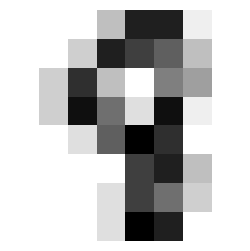

In [13]:
idx = set_sizes.index(7)

img_idx = X_test[idx].reshape(8, 8)

_, ax = plt.subplots(figsize=(3, 3))
ax.set_axis_off()
ax.imshow(img_idx, cmap=plt.cm.gray_r, interpolation="nearest");

This is most likely a 9, a 5 or an 8 might be possible. Let's see the model's set prediction.

In [15]:
print(f"True class: {y_test[idx]}")
print(f"Single prediction: {y_pred[idx]}")
print(f"Set prediction: {y_sets[idx]}")

True class: 8
Single prediction: 9
Set prediction: [0 1 3 5 7 8 9]
